In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import tifffile as tif
from pathlib import Path

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


---

# Dataset


In [3]:
root_dir = Path('.cache')

step_1_dir = root_dir / 'step_1a_alt'
input_dir = step_1_dir / 'input'
label_dir = step_1_dir / 'label'

In [4]:
input_files = sorted(list(input_dir.glob('*.tif')))
print(f"Total: {len(input_files)} files\n")

Total: 7920 files



In [5]:
idx = 130

input_file = input_files[idx]
label_file = label_dir / input_file.name
input_img = tif.imread(input_file)
label_img = tif.imread(label_file)
print(f"Selected: {input_file.name}")

Selected: 1026_2_train.tif


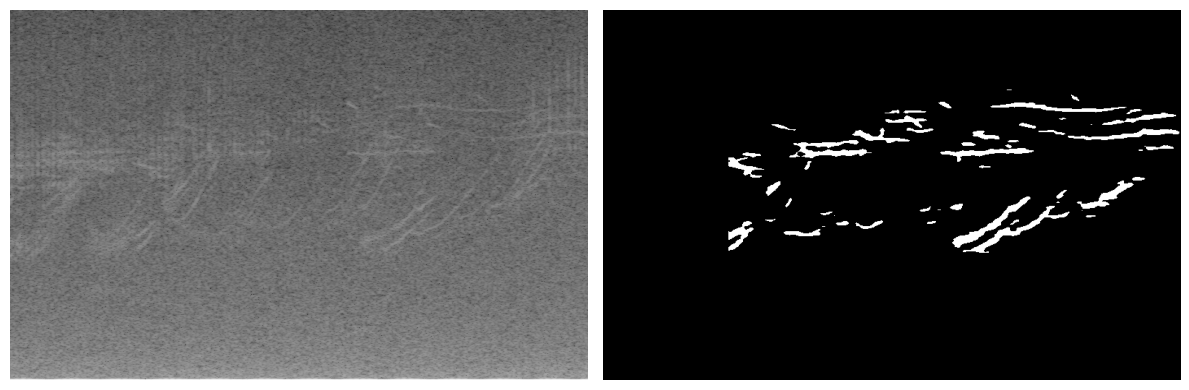

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

im1 = ax1.imshow(input_img, cmap='gray', aspect='auto', origin='lower')
ax1.axis('off')

im2 = ax2.imshow(label_img, cmap='gray', aspect='auto', origin='lower')
ax2.axis('off')

plt.tight_layout()
plt.show()

In [7]:
step_2_dir = root_dir / 'step_2_coco' / 'train'

input_files = sorted(list(input_dir.glob('*.tif')))
input_file = input_files[idx]
input_img = tif.imread(input_file)

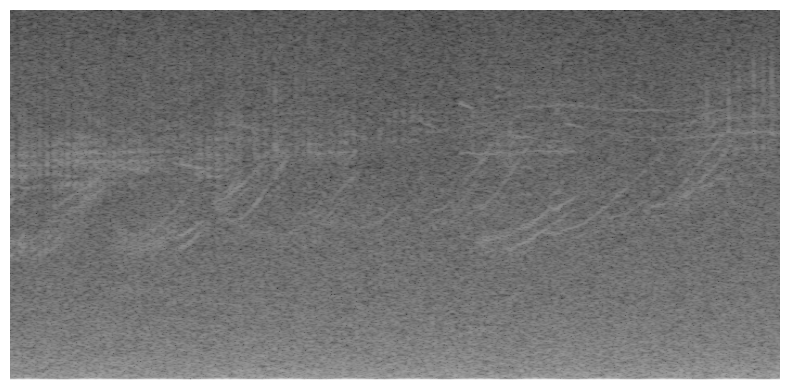

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

im = ax.imshow(input_img, cmap='gray', aspect='auto', origin='lower')
ax.axis('off')

plt.tight_layout()
plt.show()

---

# Instance Segmentation


In [9]:
def prepare_image(img):
    img = img.astype(np.float32)
    img = np.stack([img] * 3, axis=0)
    img = torch.from_numpy(img)
    return img


def draw_boxes(ax, boxes, labels=None, scores=None, color='red', linewidth=2):
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=linewidth,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)
        
        if scores is not None:
            score = scores[i]
            ax.text(x1, y1 - 2, f'{score:.2f}', color=color, fontsize=8)


def draw_masks(ax, masks, alpha=0.5, cmap='jet'):
    if len(masks) == 0:
        return

    h, w = masks[0].shape
    combined = np.zeros((h, w, 4))  # RGBA
    
    colors = plt.get_cmap(cmap, len(masks))
    
    for i, mask in enumerate(masks):
        color = colors(i)
        mask_bool = mask > 0.5
        for c in range(3):
            combined[:, :, c] = np.where(mask_bool, color[c], combined[:, :, c])
        combined[:, :, 3] = np.where(mask_bool, alpha, combined[:, :, 3])
    
    ax.imshow(combined, origin='lower', aspect='auto')


In [10]:
def load_faster_rcnn(model_path):
    from aemodes.models.instance.faster_rcnn import load_model
    model = load_model(model_path)
    model.eval()
    return model

def load_mask_rcnn(model_path):
    from aemodes.models.instance.mask_rcnn import load_model
    model = load_model(model_path)
    model.eval()
    return model

def load_yolo(model_path):
    from ultralytics import YOLO
    
    # Load model
    model = YOLO(model_path)
    return model

def load_model(path, model_type):
    match model_type:
        case 'faster_rcnn':
            return load_faster_rcnn(path)
        case 'mask_rcnn':
            return load_mask_rcnn(path)
        case 'yolo_detect':
            return load_yolo(path)
        case 'yolo_segment':
            return load_yolo(path)
        case _:
            print(f"Invalid model type: {model_type}")

In [11]:
def pred_faster_rcnn(model, inp, threshold=0.5):
    with torch.no_grad():
        pred = model([inp])[0]
    keep = pred['scores'] > threshold
    return {
        'boxes': pred['boxes'][keep].cpu().numpy(),
        'scores': pred['scores'][keep].cpu().numpy(),
    }

def pred_mask_rcnn(model, inp, threshold=0.5):
    with torch.no_grad():
        pred = model([inp])[0]
    keep = pred['scores'] > threshold
    return {
        'boxes': pred['boxes'][keep].cpu().numpy(),
        'scores': pred['scores'][keep].cpu().numpy(),
        'masks': pred['masks'][keep].squeeze(1).cpu().numpy(),
    }

def pred_yolo_detect(model, inp, threshold=0.5):
    pred = model(inp, verbose=False, conf=threshold)[0]
    return {
        'boxes': pred.boxes.xyxy.cpu().numpy(),
        'scores': pred.boxes.conf.cpu().numpy(),
    }

def pred_yolo_segment(model, inp, threshold=0.5):
    pred = model(inp, verbose=False, conf=threshold)[0]
    return {
        'boxes': pred.boxes.xyxy.cpu().numpy(),
        'scores': pred.boxes.conf.cpu().numpy(),
        'masks': pred.masks.data.cpu().numpy(),
    }

def run_model(model_name, model, inp, threshold=0.5):
    match model_name:
        case 'faster_rcnn':
            result = pred_faster_rcnn(model, inp, threshold)
        case 'mask_rcnn':
            result = pred_mask_rcnn(model, inp, threshold)
        case 'yolo_detect':
            inp = torch.nn.functional.interpolate(
                inp.unsqueeze(0), size=(640, 640), 
                mode='bilinear', align_corners=False
                ).squeeze(0)
            result = pred_yolo_detect(model, inp.unsqueeze(0), threshold)
        case 'yolo_segment':
            inp = torch.nn.functional.interpolate(
                inp.unsqueeze(0), size=(640, 640), 
                mode='bilinear', align_corners=False
                ).squeeze(0)
            result = pred_yolo_segment(model, inp.unsqueeze(0), threshold)
        case _:
            raise ValueError(f"Invalid model type: {model_name}")
    
    return result

In [12]:
model_dir = Path('../model')

models = {
    'faster_rcnn': {
        'path': model_dir / 'faster_rcnn.pt',
        'available': False,
        'model': None
    },
    'mask_rcnn': {
        'path': model_dir / 'mask_rcnn.pt',
        'available': False,
        'model': None
    },
    # 'yolo_detect': {
    #     'path': model_dir / 'yolo' / 'detect' / 'weights' / 'best.pt',
    #     'available': False,
    #     'model': None
    # },
    # 'yolo_segment': {
    #     'path': model_dir / 'yolo' / 'segment' / 'weights' / 'best.pt',
    #     'available': False,
    #     'model': None
    # }
}

print("Available models:")
for model_name, model_info in models.items():
    if model_info['path'].exists():
        print(f"{model_name}")
        model_info['available'] = True
        model_info['model'] = load_model(model_info['path'], model_name)
    else:
        model_info['available'] = False

Available models:
faster_rcnn
mask_rcnn


In [30]:
idx = 190
input_file = input_files[idx]
label_file = label_dir / input_file.name
input_img = tif.imread(input_file)
label_img = tif.imread(label_file)
print(f"Input Size: {input_img.shape}")
print(f"Label Size: {label_img.shape}")
print(f"Input Mean: {input_img.mean()}, Std: {input_img.std()}")

Input Size: (512, 710)
Label Size: (512, 710)
Input Mean: 0.1487114280462265, Std: 0.7974595427513123


In [31]:
threshold = 0.5

all_results = {}

input_tensor = prepare_image(input_img)
for model_name, model_info in models.items():
    if model_info['available']:
        model = model_info['model']
        result = run_model(model_name, model, input_tensor, threshold)
        all_results[model_name] = result

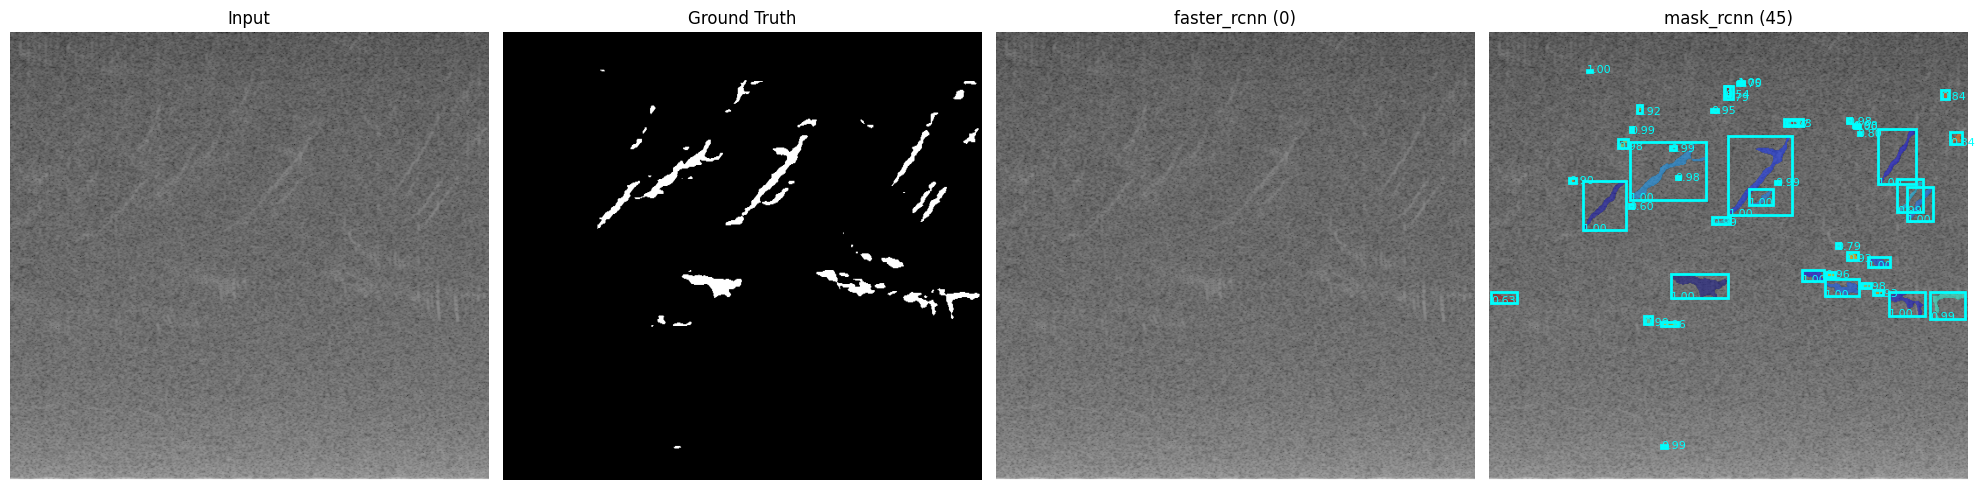

In [32]:
# Create comparison figure
n_models = len(all_results)
if n_models > 0:
    fig, axes = plt.subplots(1, n_models + 2, figsize=(5 * (n_models + 2), 5))
    
    # Input
    axes[0].imshow(input_img, cmap='gray', aspect='auto', origin='lower')
    axes[0].set_title('Input')
    axes[0].axis('off')
    
    # Ground Truth
    axes[1].imshow(label_img, cmap='gray', aspect='auto', origin='lower')
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    
    # Model predictions
    colors = ['lime', 'cyan', 'magenta', 'yellow']
    for i, (model_name, result) in enumerate(all_results.items()):
        ax = axes[i + 2]
        ax.imshow(input_img, cmap='gray', aspect='auto', origin='lower')
        
        # Draw masks if available
        if 'masks' in result and len(result['masks']) > 0:
            draw_masks(ax, result['masks'], alpha=0.5)
        
        # Draw boxes
        if len(result['boxes']) > 0:
            draw_boxes(ax, result['boxes'], scores=result['scores'], 
                      color=colors[i % len(colors)], linewidth=2)
        
        ax.set_title(f'{model_name} ({len(result["boxes"])})')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No models loaded. Train models first.")
